In [1]:
#SCRAPE MULTIPLE FINANCIAL PARAMETERS FROM SINGLE PAGE / V2 / Faster scrolling using drag&drop apprach
#https://stackoverflow.com/questions/62119348/how-to-scroll-horizontally-using-selenium-chromedriver-in-python

import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
import json
from html.parser import HTMLParser
import sqlite3


In [2]:
#scrape the data

#HTML parser that help to parse html-strings
#https://www.educative.io/answers/what-is-the-html-parser-in-python
class Parser(HTMLParser):
  def handle_data(self, data):
    self.output = data
parser = Parser()


class ScrapeMacrotrend():

    def __init__(self, ticker_search, scrape_again=False):
        
        url = self.get_company_page_url(ticker_search) #find url for the respective company based on ticker-name
        # url = 'https://www.macrotrends.net/stocks/charts/TSLA/tesla/income-statement?freq=Q'

        #scrape and store company quarter data if not available in database. If data already exists in database, return it from there.
        if self.data_already_in_database(name= (ticker_search + '_financial_statements_quarter'))==False or scrape_again==True:
            self.financial_statements_quarter = self.scrape_the_data(url + '/income-statement?freq=Q')
            self.store_data_in_database(data=self.financial_statements_quarter, name= (ticker_search + '_financial_statements_quarter'))
        else:
            self.financial_statements_quarter = self.get_from_database(name= (ticker_search + '_financial_statements_quarter'))

        if self.data_already_in_database(name= (ticker_search + '_balance_sheet_quarter'))==False or scrape_again==True:
            self.balance_sheet_quarter = self.scrape_the_data(url + '/balance-sheet?freq=Q')
            self.store_data_in_database(data=self.balance_sheet_quarter, name= (ticker_search + '_balance_sheet_quarter'))
        else:
            self.balance_sheet_quarter = self.get_from_database(name= (ticker_search + '_balance_sheet_quarter'))

        if self.data_already_in_database(name= (ticker_search + '_cash_flow_quarter'))==False or scrape_again==True:
            self.cash_flow_quarter = self.scrape_the_data(url + '/cash-flow-statement?freq=Q')
            self.store_data_in_database(data=self.cash_flow_quarter, name= (ticker_search + '_cash_flow_quarter'))
        else:
            self.cash_flow_quarter = self.get_from_database(name= (ticker_search + '_cash_flow_quarter'))


        if self.data_already_in_database(name= (ticker_search + '_financial_ratios_quarter'))==False or scrape_again==True:
            self.financial_ratios_quarter = self.scrape_the_data(url + '/financial-ratios?freq=Q')
            self.store_data_in_database(data=self.financial_ratios_quarter, name= (ticker_search + '_financial_ratios_quarter'))
        else:
            self.financial_ratios_quarter = self.get_from_database(name= (ticker_search + '_financial_ratios_quarter'))
        
        #scrape company anual data
        if self.data_already_in_database(name= (ticker_search + '_financial_statements_annual'))==False or scrape_again==True:
            self.financial_statements_annual = self.scrape_the_data(url + '/income-statement?freq=A')
            self.store_data_in_database(data=self.financial_statements_annual, name= (ticker_search + '_financial_statements_annual'))
        else:
            self.financial_statements_annual = self.get_from_database(name= (ticker_search + '_financial_statements_annual'))

        if self.data_already_in_database(name= (ticker_search + '_balance_sheet_annual'))==False or scrape_again==True:
            self.balance_sheet_annual = self.scrape_the_data(url + '/balance-sheet?freq=A')
            self.store_data_in_database(data=self.balance_sheet_annual, name= (ticker_search + '_balance_sheet_annual'))
        else:
            self.balance_sheet_annual = self.get_from_database(name= (ticker_search + '_balance_sheet_annual'))

        if self.data_already_in_database(name= (ticker_search + '_cash_flow_annual'))==False or scrape_again==True:
            self.cash_flow_annual = self.scrape_the_data(url + '/cash-flow-statement?freq=A')
            self.store_data_in_database(data=self.cash_flow_annual, name= (ticker_search + '_cash_flow_annual'))
        else:
            self.cash_flow_annual = self.get_from_database(name= (ticker_search + '_cash_flow_annual'))

        if self.data_already_in_database(name= (ticker_search + '_financial_ratios_annual'))==False or scrape_again==True:
            self.financial_ratios_annual = self.scrape_the_data(url + '/financial-ratios?freq=A')
            self.store_data_in_database(data=self.financial_ratios_annual, name= (ticker_search + '_financial_ratios_annual'))
        else:
            self.financial_ratios_annual = self.get_from_database(name= (ticker_search + '_financial_ratios_annual'))


    def get_company_page_url(self, ticker_search):
        #get ticker data
        tickers_url = 'https://www.macrotrends.net/assets/php/ticker_search_list.php?_=1664947632720'
        data_tickers = requests.get(tickers_url)
        data_tickers = data_tickers.text
        data_tickers_json = json.loads(data_tickers)

        #search for the company-url
        for item in data_tickers_json:
            # print(item['s'])
            if ticker_search in item['s']: #example: AAPL/apple
                company_page_url = item['s']
                # print("company-url={}".format(company_page_url))

        return 'https://www.macrotrends.net/stocks/charts/' + company_page_url


    def scrape_the_data(self, url):

        page = requests.get(url)
        page_lines = page.text.splitlines()
        for line in page_lines:
            if 'var originalData =' in line: #the line where all the data is storred
                data = line #store the information in a variable

        data = data[20:-1] # remove the the unneeded informatino from the line
        data_json = json.loads(data) #convert the line to a json-object

        #the following vars are needed when looping through the json_
        data_index = [] #collect the data-names
        data_column = [] #collect the data-dates
        data_values = [] #collect the data-values

        #loop over 
        for item in data_json:

            #reset temp-vars for the next loop
            data_values_temp = [] #store data-values for current loop
            data_column_temp = [] #store data-dates for current loop

            for key in item.items() :
                # print(key[0], key[1])

                if (key[0] != 'field_name') and (key[0] != 'popup_icon'): # dates and values
                    # print(key[0], key[1])
                    data_column_temp.append(key[0]) #dates
                    data_values_temp.append(key[1]) #values

                elif key[0] == 'field_name': #data-names
                    # print(key[1])
                    parser.feed(key[1])
                    # print(parser.output)
                    data_index.append(parser.output) # xxx = "<a href='/stocks/charts/TSLA/tesla/cost-goods-sold'>Cost Of Goods Sold</a>"

                elif key[0]== 'popup_icon': #data-graph link (not needed)
                    continue
                    print(key[1])

            #add temp-vars to permanent ones
            data_values.append(data_values_temp)
            data_column.append(data_column_temp)


        # pd.DataFrame(data=data_values, index=data_index, columns=data_column, dtype=None, copy=None)
        company_data = pd.DataFrame(data=data_values, index=data_index, columns=data_column[0])
        company_data.apply(self.fixData)

        return company_data

    #apply-function that goes over all dataframe-elements and converts them to numeric value if possible
    def fixData(sekf, input_data):
        
        for i in range(len(input_data)):
        
            try:
                input_data[i] = pd.to_numeric(input_data[i])
                # print(type(input_data[i]), "converted to numeric")

            except:
                # pass
                print(input_data[i], "Can't convert to numeric")
            
        return input_data
        

    def store_data_in_database(self, data, name):
        database = "company_database.db"
        conn = sqlite3.connect(database)
        data.to_sql(name=name, con=conn, if_exists='replace')
        conn.close()


    def data_already_in_database(self, name):

        output = False
        conn = sqlite3.connect('company_database.db')
        c = conn.cursor()
                    
        #get the count of tables with the name
        c.execute(''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='{}' '''.format(name))

        #if the count is 1, then table exists
        if c.fetchone()[0]==1:
            # print('Table exists.', name)
            output = True
			
        #commit the changes to db			
        conn.commit()
        #close the connection
        conn.close()

        # print(name, output)
        return output

    def get_from_database(self, name):
        conn = sqlite3.connect('company_database.db')
        output = pd.read_sql_query(f"SELECT * from {name}", conn) #get the data from database and put it in pandas-dataframe
        output_index = output.set_index('index', inplace=False) #set the index-column as dataframe-index, needed because otherwise the dataframe index won't be parameter names but integers
        # print(output)
        # print(output1)
        conn.close()
        return output_index

    # company_data.dtypes
    # company_data.columns
    # company_data.index

    # company_data.loc['Revenue']
    # company_data.loc['EPS - Earnings Per Share']

    # company_data.columns = pd.to_datetime(company_data.columns) #change columns data-type to datetime.
    # company_data.columns




In [3]:
apple_data = ScrapeMacrotrend('AAPL')
tesla_data = ScrapeMacrotrend('TSLA')
microsoft_data = ScrapeMacrotrend('MSFT')
amazon_data = ScrapeMacrotrend('AMZN')
google_data = ScrapeMacrotrend('GOOG')

# apple_data1 = ScrapeMacrotrend('AAPL')
# tesla_data1 = ScrapeMacrotrend('TSLA')
# microsoft_data1 = ScrapeMacrotrend('MSFT')
# amazon_data1 = ScrapeMacrotrend(ticker_search='AMZN')

#tesla_data.financial_statements_annual
# print(amazon_data.financial_statements_quarter.index.to_list())
# print(amazon_data1.financial_statements_quarter.index.to_list())

# amazon_data.financial_statements_quarter.columns

# amazon_data2 = amazon_data1.financial_statements_quarter.copy()
# print(amazon_data2.columns)
# amazon_data2.drop('index', axis=1, inplace=True) 
# amazon_data2.set_index('index', inplace=True)
# print(amazon_data2.columns)

# amazon_data.financial_statements_quarter
# amazon_data1.financial_statements_quarter
# amazon_data2

# amazon_data3 = ScrapeMacrotrend(ticker_search='AMZN')
# amazon_data3.financial_statements_quarter


Revenue


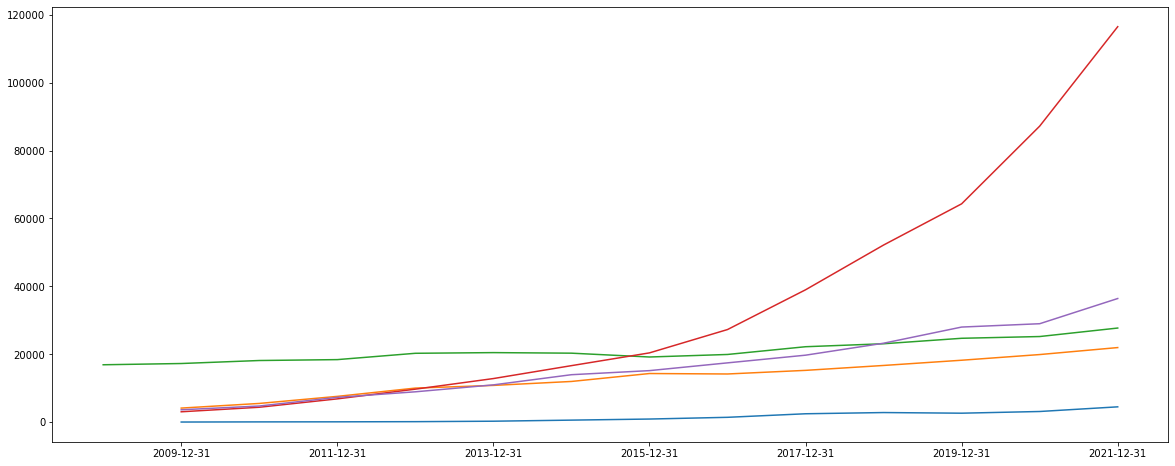

In [4]:
#plotting the data
plt.figure(figsize=(20,8)) #set figure size

# tesla_data.financial_ratios_quarter.loc['Current Ratio'].plot()
# apple_data.financial_ratios_quarter.loc['Current Ratio'].plot()

print(tesla_data.financial_statements_annual.index[0])
param_name = tesla_data.financial_statements_annual.index[4] #get parameter name from dataframe columns

tesla_data.financial_statements_annual.loc[param_name].plot()
apple_data.financial_statements_annual.loc[param_name].plot()
microsoft_data.financial_statements_annual.loc[param_name].plot()
amazon_data.financial_statements_annual.loc[param_name].plot()
google_data.financial_statements_annual.loc[param_name].plot()
plt.plot()

#invert x-axis (2009 on the left, 2022 on the right)
ax = plt.gca()
ax.invert_xaxis()

plt.show()

In [20]:

#get all ticker-urls and put them in the database

class getAllCompanyTickers():

    def __init__(self):

        self.tickers_data = self.download_tickers()
        self.store_data_in_database(self.tickers_data, "Macrotrends_Tickers_URLs")

    def download_tickers(self):

        tickers_data =[]
        #donwnload ticker-page
        tickers_url = 'https://www.macrotrends.net/assets/php/ticker_search_list.php?_=1664947632720'
        data_tickers = requests.get(tickers_url)
        data_tickers = data_tickers.text
        data_tickers_json = json.loads(data_tickers)

        #search for the company-url
        for item in data_tickers_json:
            # print(item['s'])
            tickers_data.append(item['s'])

        outut = pd.DataFrame(tickers_data)

        return outut

    def store_data_in_database(self, data, name):
        database = "company_database.db"
        conn = sqlite3.connect(database)
        data.to_sql(name=name, con=conn, if_exists='replace',  index=False)
        conn.close()


        
output = getAllCompanyTickers()



TypeError: to_sql() got an unexpected keyword argument 'header'